# Accessing the Dataset

In [136]:
import prepare_data
import pandas as pd
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer

In [122]:
simple_path = "data/simple.aligned"
normal_path = "data/normal.aligned"

In [129]:
s_sent_col = "simple_sentence"
n_sent_col = "normal_sentence"

In [182]:
aligned_data = list(prepare_data.get_aligned_sentences(simple_path,normal_path))
df = prepare_data.create_df(aligned_data)

In [ ]:
df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: nltk.word_tokenize(x))

In [185]:
df = df.loc[df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
df = df.loc[df[s_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]

In [186]:
#df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: nltk.word_tokenize(x))
df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: list(zip(*nltk.pos_tag(x))))

In [187]:
df["s_sent"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][0],axis=1)
df["s_pos"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][1],axis=1)

In [173]:
df["n_sent"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][0],axis=1)
df["n_pos"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][1],axis=1)

In [177]:
df = df.drop([s_sent_col,n_sent_col],axis=1)

In [178]:
df.to_csv("data/wikipedia_aligned_pos.csv",index=False,sep="|")

# Feature Implementation

## Word and Sentence Length

In [140]:
list(zip(*nltk.pos_tag(["I","like","apples","."])))

[('I', 'like', 'apples', '.'), ('PRP', 'VBP', 'NNS', '.')]

In [ ]:
def pos_tagging(sentence):
    np.array(sentence).vectorize(lambda x: nltk.pos_tag())

In [137]:
def get_wordnet_pos(self, treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def penn_to_wn(tag):
    return get_wordnet_pos(tag)

In [78]:
def count_sent_word_length(df):
    df[["simple_sentence","normal_sentence"]] = df[["simple_sentence","normal_sentence"]].applymap(lambda x: nltk.word_tokenize(x))
    lemmatizer = WordNetLemmatizer()
    df[[n_sent_col,s_sent_col]] = df[[n_sent_col,s_sent_col]].applymap(lambda x: lemmatizer.lemmatize(x))
    len_mean_sents = df[["simple_sentence","normal_sentence"]].applymap(lambda x: (len(x),np.mean([len(word) for word in x])))
    df[['s_sent_len', 's_word_mean']] = len_mean_sents["simple_sentence"].apply(pd.Series)
    df[['n_sent_len', 'n_word_mean']] = len_mean_sents["normal_sentence"].apply(pd.Series)
    return df

In [79]:
df = count_sent_word_length(df)

In [80]:
df.head()

,simple_topic,simple_numb,simple_sentence,normal_topic,normal_numb,normal_sentence,s_sent_len,s_word_mean,n_sent_len,n_word_mean
0,"cherokee, oklahoma",0,"[cherokee, is, a, city, of, oklahoma, in, the,...","cherokee, oklahoma",0,"[cherokee, is, a, city, in, alfalfa, county, ,...",11.0,3.909091,13.0,4.076923
1,skateboard,2,"[skateboard, decks, are, normally, between, 28...",skateboard,5,"[skateboard, decks, are, usually, between, 28,...",11.0,4.636364,11.0,4.545455
2,skateboard,2,"[the, bottom, of, the, deck, can, be, printed,...",skateboard,5,"[the, underside, of, the, deck, can, be, print...",21.0,3.190476,24.0,3.958333
3,skateboard,3,"[the, longboard, was, made, by, two, surfers, ...",skateboard,6,"[this, was, created, by, two, surfers, ;, ben,...",14.0,4.142857,13.0,4.076923
4,skateboard,2,"[other, materials, used, in, making, decks, fi...",skateboard,5,"[some, of, them, have, special, materials, tha...",22.0,4.272727,33.0,4.030303


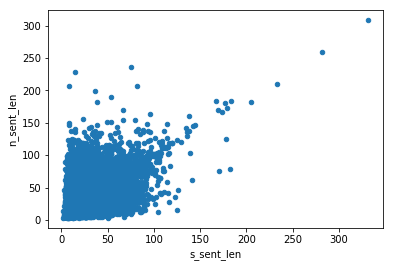

In [49]:
df.plot.scatter(x="s_sent_len",y="n_sent_len")

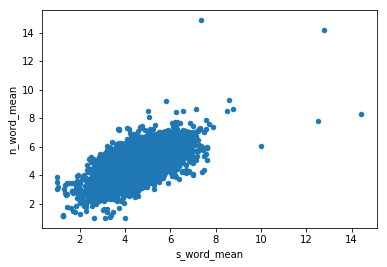

In [50]:
df.plot.scatter(x="s_word_mean",y="n_word_mean")

## Basic English

In [68]:
with open("data/basic_english.txt","r") as f:
    data = f.read()
    words = data.split(" , ")
    basic_df = pd.DataFrame(data=words,columns=["word"])
    basic_df["index"] = range(0,len(basic_df))
basic_df.head()

,word,index
0,a,0
1,able,1
2,about,2
3,account,3
4,acid,4


In [111]:
with open("data/20k_words.txt","r") as f:
    data = f.read()
    words = data.split("\n")
    english_df = pd.DataFrame(data=words,columns=["word"])
    english_df["index"] = range(0,len(english_df))
    non_basic_df = english_df.loc[~english_df["word"].isin(basic_df["word"])]
non_basic_df.head(10)

,word,index
7,is,7
10,by,10
13,i,13
15,it,15
18,be,18
19,are,19
23,your,23
27,more,27
28,an,28
29,was,29


In [130]:
#how many words are not in the basic english
df[["n_non_basic_freq","s_non_basic_freq"]] = df[[n_sent_col,s_sent_col]].applymap(
    lambda x: len(set(x).intersection(
        non_basic_df["word"].values))/len(set(x).intersection(
        english_df["word"].values)))

In [116]:
drop_bool = df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) == 0

In [103]:
set([1,2,3]).intersection(set([3,4,5])).difference(set([4,5]))

{3}

In [132]:
df.iloc[2]

simple_topic                                               skateboard
simple_numb                                                         2
simple_sentence     the bottom of the deck can be printed with a d...
normal_topic                                               skateboard
normal_numb                                                         5
normal_sentence     the underside of the deck can be printed with ...
n_non_basic_freq                                             0.952381
s_non_basic_freq                                                 0.95
Name: 2, dtype: object

In [135]:
basic_df.loc[basic_df["word"] == "printed"]

,word,index
